In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import imageio
from PIL import Image
import json
from scipy.spatial import Delaunay
import skimage as ski
import einops

def read_img(img_name, img_dir = 'in_dir/', grayscale=False, r=None):
    if '.' not in img_name:
        img_name += '.jpg'
    img = Image.open(img_dir + '/' + img_name)
    if grayscale:
        img = img.convert('L')
    img = np.array(img)
    img = img / 255
    if r:
        img = np.rot90(img, k=r)
    return img
images_out = 'images_out/' 
def save_img(fname, img_out, out_dir = images_out, grayscale=False):
    if '.jpg' not in fname:
        fname = fname + '.jpg'
    full_name = out_dir + '/' + fname
    img_out = np.clip(img_out, a_min=0, a_max=1)
    # img_out = (img_out*255).astype(np.uint8)
    if grayscale:
        imageio.imwrite(full_name, img_out)
    else:
        plt.imsave(full_name, img_out)

In [2]:
# Computes the homography p’=Hp, where H
# is a 3x3 matrix with 8 degrees of freedom
def compute_h(img_1_pts, img_2_pts):
    assert len(img_1_pts) == len(img_2_pts)
    n = len(img_1_pts)
    img_1_pts = np.asarray(img_1_pts)
    img_1_hom = to_homogenous(img_1_pts)
    img_2_pts = np.asarray(img_2_pts)
    img_2_pts_flat = np.ndarray.flatten(img_2_pts)
    
    len_H = 8
    A = np.zeros((2*n, len_H))

    A[0:-1:2, :3] = img_1_hom.T # Set first 3 columns with p
    A[1::2, 3:6] = img_1_hom.T  # Set columns 3-5 with p

    # Set end columns with p
    A[::2, -2:] = img_1_pts 
    A[1::2, -2:] = img_1_pts 

    # Multiply end columns with p'
    A[:, -2] *= -img_2_pts_flat
    A[:, -1] *= -img_2_pts_flat
    b = img_2_pts_flat
    x, res, rank, _ = np.linalg.lstsq(A, b, rcond=None)
    H = np.ones(9)
    H[:8] = x
    H = np.reshape(H, (3,3))
    return H, res, rank
# Adds ones on axis 1
def to_homogenous(inp):
    inp = np.asarray(inp)
    ones = np.ones((inp.shape[0],1))
    return np.concatenate((inp, ones), axis=1).T

# Takes homogenous points and returns normal
def homogenous_to_non(inp):
    inp = np.asarray(inp)
    z = inp[-1, :]
    inp = inp[:-1, :] / z
    return inp.T

# Applies homography to non-homogenous coordinate inp, returning the new coords
# also in non-homogenous form
def apply_h(h, inp):
    homo = to_homogenous(inp)
    transformed = h @ homo
    return homogenous_to_non(transformed)

def get_corners(img):
    img_corners = [[img.shape[1], img.shape[0]], [img.shape[1], 0], [0,0], [0, img.shape[0]]]
    return img_corners

def get_inv(A):
    return np.linalg.inv(A)

# Takes in non-homogenous points
def create_polygon(points):
    points = np.asarray(points)
    cc, rr = ski.draw.polygon(points[:,0], points[:,1], shape=None)
    return cc,rr

In [3]:
### Tests to confirm homography calculated correctly
img_1_pts = [[6,1], [2,4], [3,7], [5,4]]
img_1_pts = np.asarray(img_1_pts)
img_1_hom = to_homogenous(img_1_pts)
ans = compute_h(img_1_pts, img_1_pts)
H = ans[0]
after_H = H @ img_1_hom
assert np.all(np.isclose(img_1_hom, after_H))

H = [[10,4,6],
     [2.3,4.3,-4],
     [0, 0, 1]]
img_2_hom = H @ img_1_hom
img_2_normal = homogenous_to_non(img_2_hom)
ans = compute_h(img_1_pts, img_2_normal)
H_computed = ans[0]
assert np.all(np.isclose(H, H_computed))

In [4]:
def load_corr_pts(fname, in_dir='images_in/', single=True):
    if 'json' not in fname: fname += '.json'
    corr_file = in_dir + fname
    f = open(corr_file)
    correspondences = json.load(f)
    img_1_points = np.array(correspondences['im1Points'])
    img_2_points = np.array(correspondences['im2Points'])
    if single:
        return img_1_points
    else:
        return img_1_points, img_2_points

def plot_pts(pts, color='blue'):
    x, y = pts[:, 0], pts[:, 1]
    [plt.text(x[i], y[i], f'{i}', fontsize=10, ha='right', color=color) for i in range(len(x))]
    plt.scatter(x,y, color=color, s=5)

In [5]:
# Sets up img for interpolation
def create_interp_grid(img):
    X, Y = np.mgrid[:img.shape[0], :img.shape[1]]
    points = np.dstack((X.ravel(), Y.ravel())).squeeze()
    # Flatten img to use for interpolation
    flat_img = einops.rearrange(img, ('h w c -> (h w) c'))
    color_interp = scipy.interpolate.NearestNDInterpolator(points, flat_img)
    return color_interp

# Applies homography to img
def warp(H, img, new_shape = None, color_interp=None, out_dir='images_out/part_a/part_2/', fname=None):
    if new_shape == None: new_shape = img.shape
    new_image = np.zeros(new_shape)
    cc, rr = create_polygon(get_corners(new_image))
    src_coords = np.array([cc, rr, np.ones_like(rr)])

    new = homogenous_to_non(get_inv(H) @ src_coords)   # Apply transformation to get pts in original image
    c_n, r_n = new[:, 0], new[:, 1]
    rr = np.clip(rr, 0, new_image.shape[0]-1)
    cc = np.clip(cc, 0, new_image.shape[1]-1)

    # Interpolate at to get the colors of the points when inv mapped
    mask_c = c_n < img.shape[1]
    mask_c *= c_n >= 0
    mask_c = np.repeat(mask_c[:, np.newaxis], 3, axis=1)

    mask_r = r_n < img.shape[0]
    mask_r *= r_n >= 0
    mask_r = np.repeat(mask_r[:, np.newaxis], 3, axis=1)
    # mask = mask_r * mask_c

    if color_interp == None:
        color_interp = create_interp_grid(img)
    tri_interp = color_interp((r_n, c_n))
    tri_interp_mask_c = np.where(mask_c, tri_interp, np.ones(3))
    tri_interp_mask_rc = np.where(mask_r, tri_interp_mask_c, np.ones(3))

    # new_image[rr, cc] = tri_interp
    new_image[rr, cc] = tri_interp_mask_rc
    plt.imshow(new_image)
    if fname != None:
        save_img(fname, new_image, out_dir=out_dir)
    return new_image

In [6]:
def shift_pts(pts, w_extend=0, h_extend=0, offset_x=0, offset_y=0):
    new_pts = pts.copy()
    for i in range(len(pts)):
        new_pts[i] = pts[i][0] + (-1)**(i<2)* w_extend + offset_x, pts[i][1] + (-1)**(i==0 or i==3)* h_extend + offset_y
    return new_pts
        
def get_pts_from_corner(pts, tl, br, w_extend=0, h_extend=0, offset_x=0, offset_y=0):
    top_left, bottom_right = pts[tl], pts[br]
    h, w = -top_left[1] + bottom_right[1], bottom_right[0] - top_left[0]
    top_right = bottom_right[0], bottom_right[1] - h
    bottom_left = bottom_right[0] - w, bottom_right[1]
    pts = np.asarray([top_left, bottom_left, bottom_right, top_right])
    return shift_pts(pts, w_extend=w_extend, h_extend=h_extend, offset_x=offset_x, offset_y=offset_y)

In [7]:
img_dir = 'images_in/'

macbook_pts = load_corr_pts('macbook_new', single=True)
img = read_img('macbook_new', img_dir)

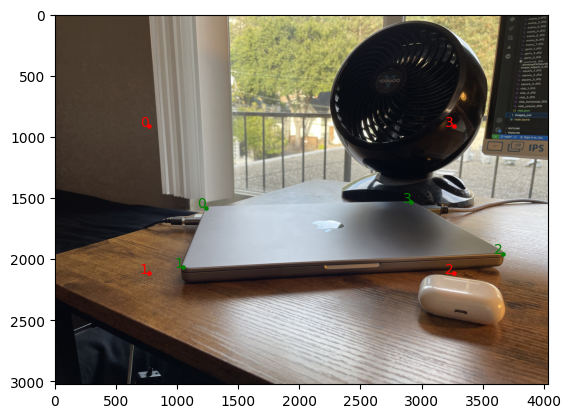

In [9]:
w, h = 1250, 600
x, y = 2016, 1512
# target_pts = np.asarray([[x+w,y+h], [x+w,y-h], [x-w,y-h], [x-w,y+h]])
target_mac_pts = np.asarray([[x-w,y-h], [x-w,y+h], [x+w,y+h], [x+w,y-h] ])
# img_2_points = get_corners(img)

plot_pts(macbook_pts, color='green')
plot_pts(target_mac_pts, color='red')
H, _, _ = compute_h(macbook_pts, target_mac_pts)

plt.imshow(img)

In [9]:
macbook_interp = create_interp_grid(img)

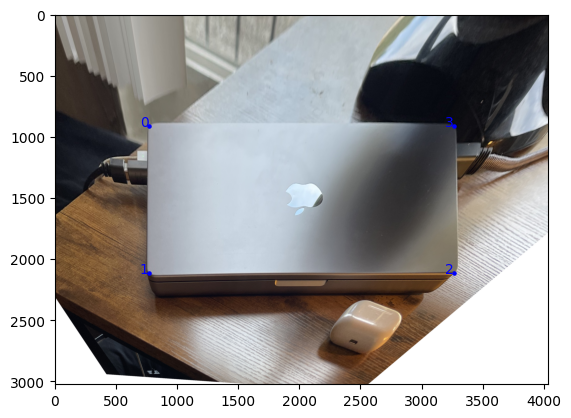

In [10]:
H, _, _ = compute_h(macbook_pts, target_mac_pts)
plot_pts(target_mac_pts)
mac_rectified = warp(H, img, color_interp=macbook_interp, fname='macbook_new')

(3024, 4032, 3)

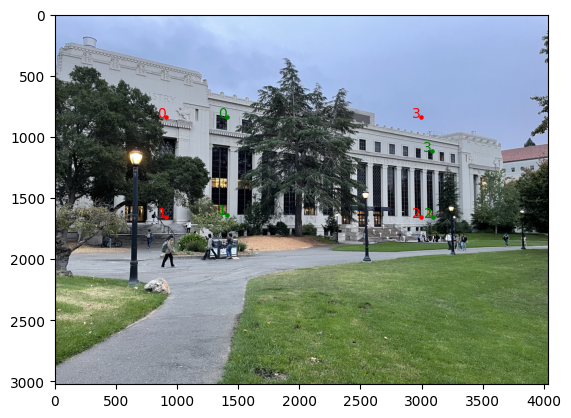

In [14]:
vlsb_pts = load_corr_pts('vlsb', single=True)
vlsb = read_img('vlsb_horizontal', img_dir)
target_vlsb_pts = get_pts_from_corner(vlsb_pts, 0, -1, w_extend=200, offset_x=-300)
plt.imshow(vlsb)
vlsb_pts_4 = np.asarray([vlsb_pts[0,:], vlsb_pts[3,:], vlsb_pts[-1,:], vlsb_pts[4,:]])
plot_pts(vlsb_pts_4, color='green')
plot_pts(target_vlsb_pts, color='red')
vlsb.shape

In [20]:
vlsb_interp = create_interp_grid(vlsb)
H, _, _ = compute_h(vlsb_pts_4, target_vlsb_pts)

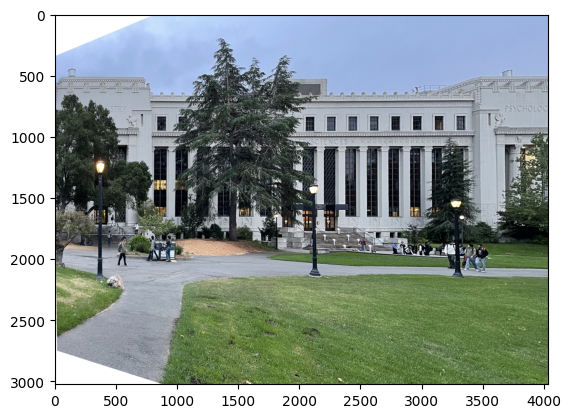

In [21]:
vlsb_warped = warp(H, vlsb, color_interp=vlsb_interp, fname='vlsb_final')

(3024, 4032, 3)

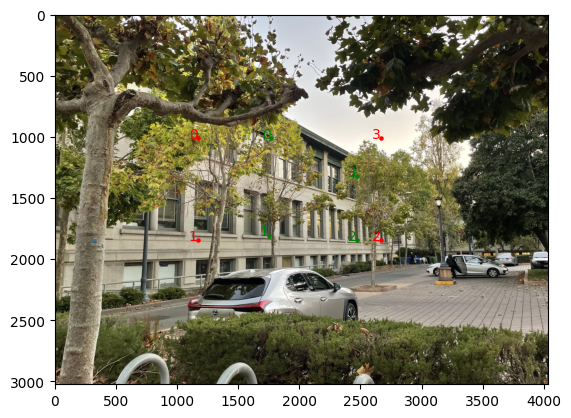

In [17]:
building_pts = load_corr_pts('building', single=True)
building = read_img('building', img_dir)
target_bldg_pts = get_pts_from_corner(building_pts, 0, 2, w_extend=400, offset_x=-200)
plt.imshow(building)
# img_pts_4 = np.asarray([vlsb_pts[0,:], vlsb_pts[3,:], vlsb_pts[-1,:], vlsb_pts[4,:]])
plot_pts(building_pts, color='green')
plot_pts(target_bldg_pts, color='red')
building.shape

In [18]:
bldg_interp = create_interp_grid(building)
H, _, _ = compute_h(building_pts, target_bldg_pts)

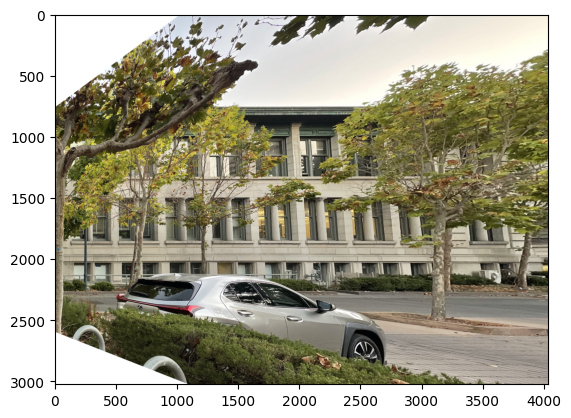

In [19]:
bldg_warped = warp(H, building, color_interp=bldg_interp, fname='bldg')

### Part 3: Mosaics

In [22]:
vlsb_center_1_pts, vlsb_right_pts = load_corr_pts('vlsb_2_to_1', single=False)

vlsb_left = read_img('vlsb_3', img_dir, r=3)
vlsb_center = read_img('vlsb_2', img_dir, r=3)
vlsb_right = read_img('vlsb_1', img_dir, r=3)

# target_vlsb_pts = get_pts_from_corner(vlsb_pts, 0, -1, w_extend=200, offset_x=-300)
# vlsb_pts_4 = np.asarray([vlsb_pts[0,:], vlsb_pts[3,:], vlsb_pts[-1,:], vlsb_pts[4,:]])

# plt.imshow(vlsb_center)
# plot_pts(vlsb_center_pts, color='green')
vlsb_right.shape

(4032, 3024, 3)

In [9]:
# plot_pts(vlsb_right_pts, color='red')
# plt.imshow(vlsb_right)

In [23]:
# Applies homography to img
def warp_new(H, img, corners, new_shape = None, offset=[0,0], color_interp=None, out_dir='images_out/part_a/part_2/', fname=None):
    if new_shape == None: new_shape = img.shape
    new_image = np.zeros(new_shape)
    cc, rr = create_polygon(corners)
    cc -= offset[0]
    rr -= offset[1]
    src_coords = np.array([cc, rr, np.ones_like(rr)])
    
    new = homogenous_to_non(get_inv(H) @ src_coords)   # Apply transformation to get pts in original image
    c_n, r_n = new[:, 0], new[:, 1]

    # Interpolate at to get the colors of the points when inv mapped
    mask_c = c_n < img.shape[1]
    mask_c *= c_n >= 0
    mask_c = np.repeat(mask_c[:, np.newaxis], 3, axis=1)

    mask_r = r_n < img.shape[0]
    mask_r *= r_n >= 0
    mask_r = np.repeat(mask_r[:, np.newaxis], 3, axis=1)
    # mask = mask_r * mask_c

    if color_interp == None:
        color_interp = create_interp_grid(img)
    tri_interp = color_interp((r_n, c_n))
    tri_interp_mask_c = np.where(mask_c, tri_interp, np.zeros(3))
    tri_interp_mask_rc = np.where(mask_r, tri_interp_mask_c, np.zeros(3))

    # new_image[rr, cc] = tri_interp
    cc += offset[0]
    rr += offset[1]
    rr = np.clip(rr, 0, new_image.shape[0]-1)
    cc = np.clip(cc, 0, new_image.shape[1]-1)

    new_image[rr, cc] = tri_interp_mask_rc
    plt.imshow(new_image)
    if fname != None:
        save_img(fname, new_image, out_dir=out_dir)
    return new_image

def translate_img(img, new_shape, offset_x=0, offset_y=0):
    new_img = np.zeros(new_shape)
    upper_y = min(offset_y+img.shape[0], new_img.shape[0])
    upper_x = min(offset_x+img.shape[1], new_img.shape[1])
    new_img[offset_y:upper_y, offset_x:upper_x] = img[:upper_y-offset_y, :upper_x-offset_x]
    return new_img

def make_mask_3_channel(mask):
    new_mask = np.zeros((mask.shape[0],mask.shape[1],3))
    new_mask[:,:,0] = mask
    new_mask[:,:,1] = mask
    new_mask[:,:,2] = mask
    return new_mask

In [ ]:
def compute_mosaic(name, pts_2_to_1):
    center_pts, right_pts = load_corr_pts(pts_2_to_1, single=False)

    img_left = read_img(name + '_3', img_dir, r=3)
    img_center = read_img(name + '_2', img_dir, r=3)
    img_right = read_img(name + '_1', img_dir, r=3)
    plt.imshow(img_left)

    print(img_center.shape)
    
    right_interp = create_interp_grid(img_right)
    H_1_to_2, _, _ = compute_h(right_pts, center_pts)
    
    new_right_corners = apply_h(H_1_to_2, get_corners(img_right))
    print(new_right_corners)
    max_x = int(np.max(new_right_corners[:,0]))
    max_y = int(np.max(new_right_corners[:,1]))
    min_y = int(np.min(new_right_corners[:,1]))
    min_x = int(np.min(new_right_corners[:,0]))
    
    offset_y = abs(min(0, (min_y)))
    offset_x = abs(min(0, (min_x)))
    offset = np.asarray([offset_x,offset_y])
    
    new_size = 6000
    plot_pts(new_right_corners + offset, color='green')
    plot_pts(new_right_corners + offset, color='red')
    img_1_to_2_warp = warp_new(H_1_to_2, img_right,
                                corners = new_right_corners + offset,
                                new_shape=(new_size,new_size,3),
                                # new_shape=(max(max_y, vlsb_right.shape[0]) - min(0, min_y), max(max_x, vlsb_right.shape[1]) - min(0, min_x), 3),
                                # new_shape=(max_y-min_y, max_x, 3),
                                offset=offset, color_interp=right_interp)
    
    
    

In [58]:
vlsb_right_interp = create_interp_grid(vlsb_right)
H_1_to_2, _, _ = compute_h(vlsb_right_pts, vlsb_center_1_pts)

In [59]:
new_right_corners = apply_h(H_1_to_2, get_corners(vlsb_right))
print(new_right_corners)
max_x = int(np.max(new_right_corners[:,0]))
max_y = int(np.max(new_right_corners[:,1]))
min_y = int(np.min(new_right_corners[:,1]))
min_x = int(np.min(new_right_corners[:,0]))

[[3798.17269117 4204.69944344]
 [3952.68137176 -505.97764705]
 [ 656.59833464   32.3558029 ]
 [ 700.86767327 3714.47213046]]


In [60]:
offset_y = abs(min(0, (min_y)))
offset_x = abs(min(0, (min_x)))
offset = np.asarray([offset_x,offset_y])
apply_h(H_1_to_2, get_corners(vlsb_right))+offset,

(array([[ 3.79817269e+03,  4.70969944e+03],
        [ 3.95268137e+03, -9.77647048e-01],
        [ 6.56598335e+02,  5.37355803e+02],
        [ 7.00867673e+02,  4.21947213e+03]]),)

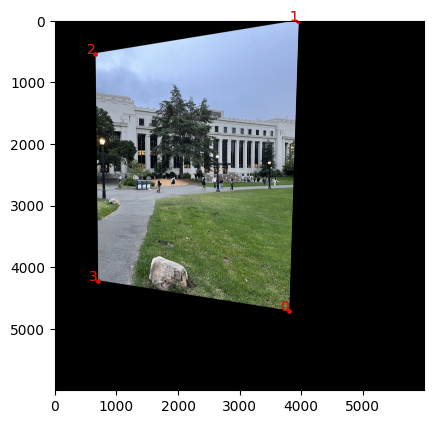

In [61]:
plot_pts(new_right_corners + offset, color='green')
plot_pts(new_right_corners + offset, color='red')
vlsb_1_to_2_warp = warp_new(H_1_to_2, vlsb_right,
                            corners=apply_h(H_1_to_2, get_corners(vlsb_right))+offset,
                            new_shape=(6000,6000,3),
                            # new_shape=(max(max_y, vlsb_right.shape[0]) - min(0, min_y), max(max_x, vlsb_right.shape[1]) - min(0, min_x), 3),
                            # new_shape=(max_y-min_y, max_x, 3),
                            offset=offset, color_interp=vlsb_right_interp)

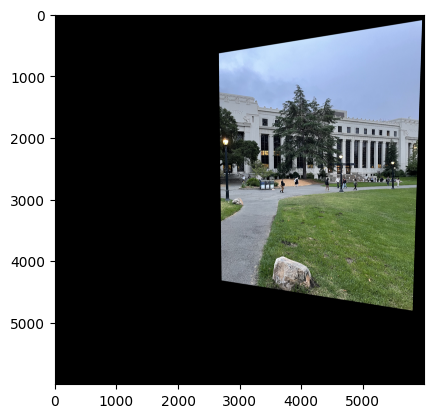

In [85]:
vlsb_1_to_2_warp_shift = translate_img(vlsb_1_to_2_warp, vlsb_1_to_2_warp.shape, offset_y=100, offset_x=2000)
plt.imshow(vlsb_1_to_2_warp_shift)

In [69]:
total_shift = offset + [2000,100]

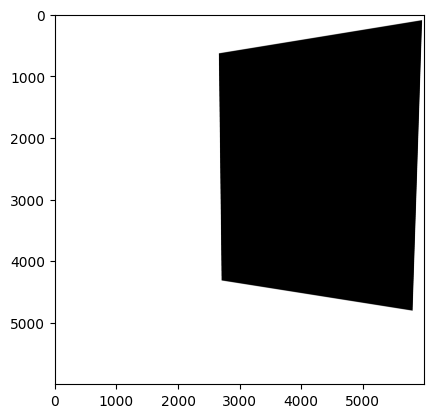

In [70]:
mask_poly = create_polygon(new_right_corners + total_shift)
cc, rr = mask_poly
mask_2_to_1 = np.ones(vlsb_1_to_2_warp.shape[:2])

rr = np.clip(rr, 0, mask_2_to_1.shape[0]-1)
cc = np.clip(cc, 0, mask_2_to_1.shape[1]-1)
mask_2_to_1[rr,cc] = 0
mask_2_to_1 = make_mask_3_channel(mask_2_to_1)
plt.imshow(mask_2_to_1)

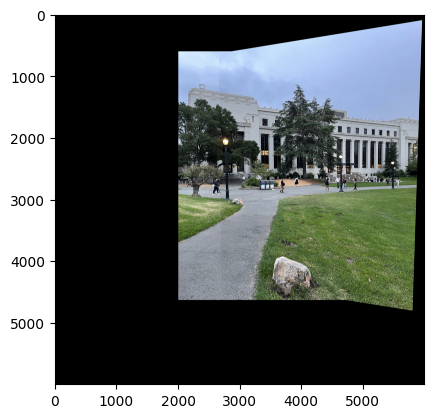

In [71]:
# plot_pts(vlsb_center_pts + offset, color='green')
vlsb_trans_center_img = translate_img(vlsb_center, vlsb_1_to_2_warp_shift.shape, offset_x=total_shift[0], offset_y=total_shift[1])
comb = vlsb_1_to_2_warp_shift + vlsb_trans_center_img*mask_2_to_1
plt.imshow(comb)

In [72]:
vlsb_center_pts, vlsb_left_pts = load_corr_pts('vlsb_2_to_3', single=False)
vlsb_center_shift_pts = shift_pts(vlsb_center_pts, offset_x=total_shift[0], offset_y=total_shift[1])
vlsb_left_interp = create_interp_grid(vlsb_left)
H_3_to_2, _, _ = compute_h(vlsb_left_pts,vlsb_center_shift_pts)

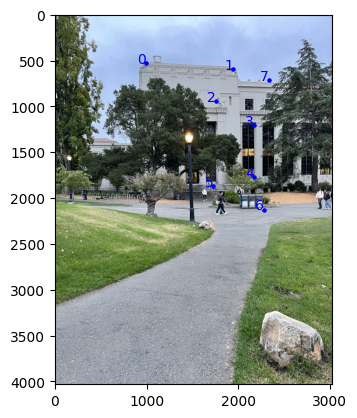

In [56]:
plot_pts(vlsb_left_pts)
plt.imshow(vlsb_left)

[[4265.27240775 4563.89673375]
 [4199.96413424  954.98260081]
 [ 945.28643044  462.69004816]
 [ 887.01234117 5233.40462599]]


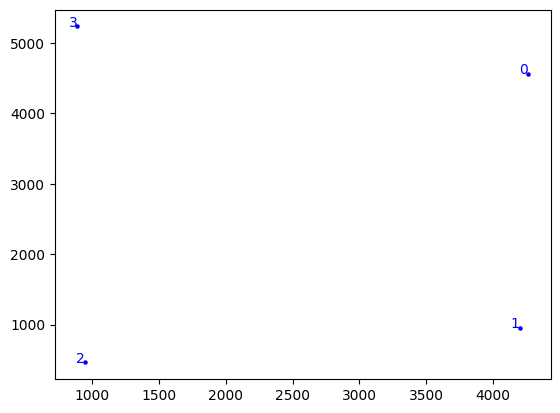

In [73]:
new_left_corners = apply_h(H_3_to_2, get_corners(vlsb_left))
plot_pts(new_left_corners)
print(new_left_corners)
max_x = int(np.max(new_left_corners[:,0]))
min_x = int(np.min(new_left_corners[:,0]))
max_y = int(np.max(new_left_corners[:,1]))
min_y = int(np.min(new_left_corners[:,1]))

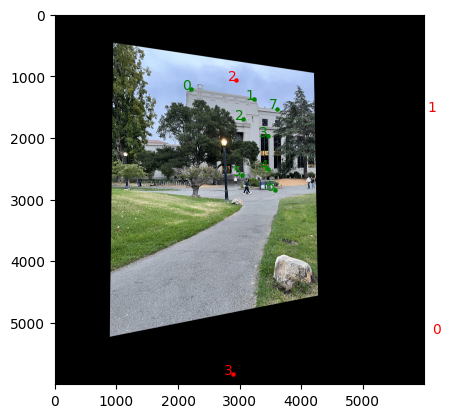

In [75]:
offset_y = abs(min(0, (min_y)))
offset_x = abs(min(0, (min_x)))
offset = np.asarray([offset_x,offset_y])
plot_pts(vlsb_center_pts + total_shift, color='green')
plot_pts(new_left_corners + offset, color='red')
vlsb_3_to_2_warp = warp_new(H_3_to_2, comb,
                            corners=apply_h(H_3_to_2, get_corners(vlsb_left)),
                            new_shape=(6000,6000,3),
                            # new_shape=(max(max_y, vlsb_left.shape[0]) + offset_y, max(max_x, vlsb_left.shape[1]) + offset_x, 3),
                            offset=offset, color_interp=vlsb_left_interp)

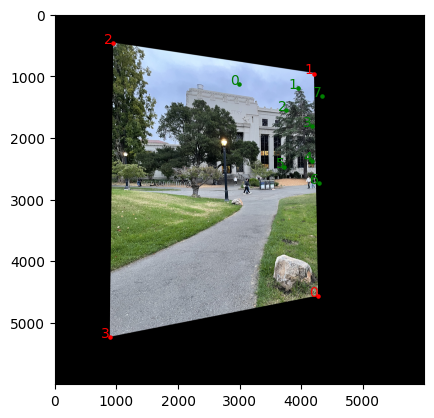

In [76]:
plot_pts(vlsb_left_pts + total_shift, color='green')
plot_pts(new_left_corners + offset, color='red')
plt.imshow(vlsb_3_to_2_warp)

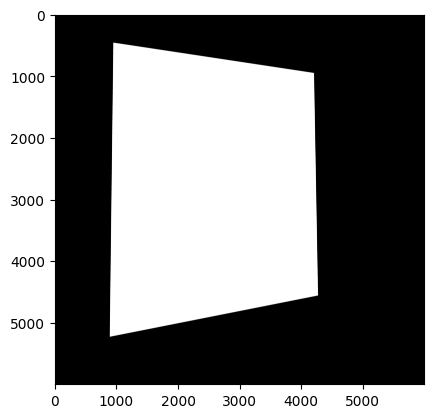

In [81]:
mask_poly = create_polygon(new_left_corners + offset)
cc, rr = mask_poly
mask_3_to_2 = np.zeros(vlsb_3_to_2_warp.shape[:2])

rr = np.clip(rr, 0, vlsb_3_to_2_warp.shape[0]-1)
cc = np.clip(cc, 0, vlsb_3_to_2_warp.shape[1]-1)
mask_3_to_2[rr,cc] = 1
mask_3_to_2 = make_mask_3_channel(mask_3_to_2)
plt.imshow(mask_3_to_2)

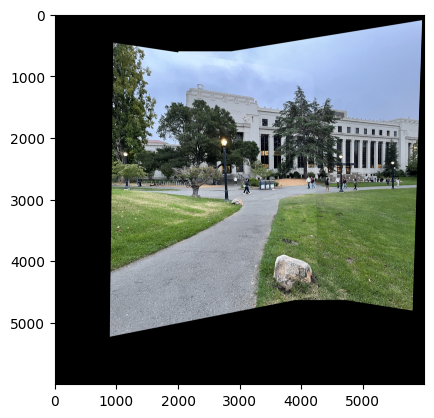

In [84]:
mosaic = vlsb_3_to_2_warp*mask_3_to_2 + comb*(1-mask_3_to_2)
plt.imshow(mosaic)
save_img('vlsb_mosaic', mosaic)

In [91]:
def reshape(img, img_to_match):
    new_img = np.zeros_like(img_to_match)
    new_img[:img.shape[0], :img.shape[1], :] = img
    return new_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


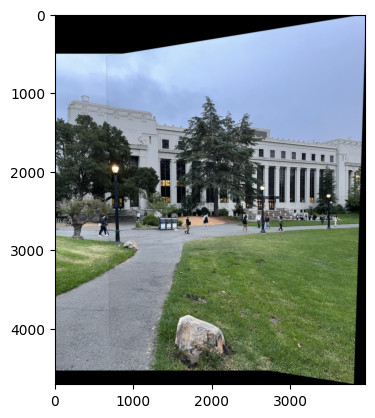

In [95]:
plt.imshow(final_img)

In [133]:
center_left_combined_shift = translate_img(final_img, vlsb_3_to_2_warp.shape, offset_x=offset[0], offset_y=offset[1])
plt.imshow(center_left_combined_shift)

ValueError: could not broadcast input array from shape (4709,3952,3) into shape (4709,3024,3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


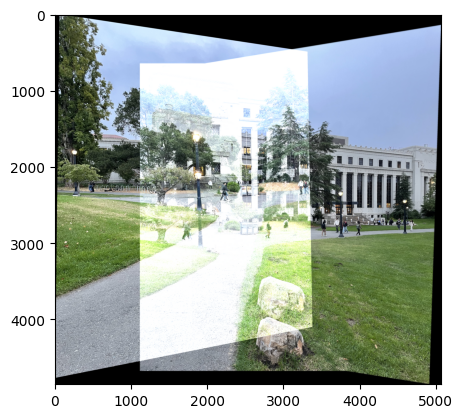

In [93]:
plt.imshow(vlsb_3_to_2_warp_reshape + center_left_combined_shift)

In [65]:
vlsb_3_to_2_warp.shape

(4770, 3377, 3)

In [88]:
dx = np.array([[1, -1]])
dy = np.array([[1], [-1]])
def convolve(filter, img):
    # res = scipy.signal.convolve(img, filter, mode='same')
    res = scipy.signal.fftconvolve(img, filter, mode='same')
    # res = scipy.signal.convolve2d(img, filter, mode='same', boundary='symm')
    # res = np.clip(res, a_min=0, a_max=1)
    return res

def create_gaussian_2d(sigma=3, ksize=19):
    gaussian_1d = cv2.getGaussianKernel(ksize, sigma)
    gaussian_2d = np.outer(gaussian_1d, gaussian_1d)
    return gaussian_2d


def create_unit_impulse(filter_shape):
    unit_impulse = np.zeros((filter_shape))
    unit_impulse[unit_impulse.shape[0]//2, unit_impulse.shape[1]//2,] = 1
    return unit_impulse

def create_sharpening_filter(alpha, sigma=3, ksize=18):
    gaussian = create_gaussian_2d(sigma, ksize)
    unit_impulse = create_unit_impulse(gaussian.shape)
    return (1+alpha) * unit_impulse - alpha * gaussian

def convolve_color(filter, img, color=True):
    res = np.zeros_like(img)
    if color:
        res[:,:,0] = convolve(filter, img[:,:,0])
        res[:,:,1] = convolve(filter, img[:,:,1])
        res[:,:,2] = convolve(filter, img[:,:,2])
    else:
        res = convolve(filter, img)
    return res

def opt_ksize(sigma):
    return 6*sigma+1

rgb_2_gray = lambda rgb : np.dot(rgb[... , :3] , [0.299 , 0.587, 0.114])
def add_images(img1, img2):
    c1, c2 =  img1.shape[2] if len(img1.shape) > 2 else 0, img2.shape[2] if len(img2.shape) > 2 else 0
    combined = np.zeros_like(img1) if c1 > c2 else np.zeros_like(img2)
    if c1 > c2:
        for c in range(c1):
            combined[:,:,c] = img1[:,:,c] + img2
    elif c2 > c1:
        for c in range(c2):
            combined[:,:,c] = img2[:,:,c] + img1
    else:
        if c1 > 0:
            for c in range(c1):
                combined[:,:,c] = img2[:,:,c] + img1[:,:,c]
        else:
            combined = img2 + img1
    return combined

In [89]:
def rescale_single(a):
    return np.interp(a, (a.min(), a.max()), (0, 1))

def rescale_all_channels(a):
    res = np.zeros_like(a)
    for c in range(a.shape[-1]):
        res[:,:,c] = rescale_single(a[:,:,c])
    return res
    
def create_gaussian_stack(img, levels, sigma=10):
    stack = np.zeros((levels, img.shape[0], img.shape[1], img.shape[2]))
    gaussian_2d = create_gaussian_2d(sigma, opt_ksize(sigma))
    
    stack[0] = img
    prev = stack[0]
    for i in range(1,levels):
        stack[i] = convolve_color(gaussian_2d, prev)
        prev = stack[i]
    return stack

def create_laplacian_stack(gaussian_stack):
    levels = gaussian_stack.shape[0] - 1
    laplacian_stack = np.zeros((levels, gaussian_stack.shape[1], gaussian_stack.shape[2], gaussian_stack.shape[3]))
    
    for i in range(levels):
        laplacian_stack[i] = gaussian_stack[i] - gaussian_stack[i+1]
    return laplacian_stack

def create_stacks(img, levels, sigma=10):
    gaussian_stack = create_gaussian_stack(img, levels+1, sigma)
    laplacian_stack = create_laplacian_stack(gaussian_stack)
    return laplacian_stack, gaussian_stack

def plot_stack(stack, save=False, vertical=False, fname='', show=True):
    levels = stack.shape[0]
    if vertical:
        fig, axes = plt.subplots(levels, 1, figsize=(20, 10))
    else:
        fig, axes = plt.subplots(1, levels, figsize=(10, 20))

    for i, ax in enumerate(axes.flat):
        ax.imshow(rescale_single(stack[i]))  
        ax.axis('off') 
    plt.tight_layout()

    if save:
        plt.savefig('part2_out_dir/part2_3/' + fname + '.jpg',bbox_inches='tight')
    
    if show:
        plt.show()
    
def sum_two_stack(stack1, stack2):
    left = np.sum(stack1, axis=0)
    right = np.sum(stack2, axis=0)
    left_extra_dim = left[np.newaxis, ...]
    right_extra_dim = right[np.newaxis, ...]

    stack1 = np.concatenate((stack1, left_extra_dim))
    stack2 = np.concatenate((stack2, right_extra_dim))

    combined = stack1 + stack2
    return left+right, stack1, stack2, combined

def create_masked_stack(img_stack, mask_stack, invert=False):
    masked_img_stack = np.zeros_like(img_stack)
    if invert:
        mask_stack = 1 - mask_stack
    levels = img_stack.shape[0]
    for i in range(levels):
        masked_img_stack[i] = img_stack[i] * mask_stack[i]
    return masked_img_stack

# Applies the mask onto img1, the inverse onto img2, creates a Laplacian stack, and then returns the collapsed image
def multires_blend(img1, img2, mask, img_sigma=4, mask_sigma=20, levels=3, save=False, fnames=[]):
    new_mask = mask
    if mask.shape != img1.shape:
        new_mask = np.zeros_like(img1)
        new_mask[:,:,0] = mask
        new_mask[:,:,1] = mask
        new_mask[:,:,2] = mask
    print(new_mask.shape)
    img1_laplacian_stack, img1_gaussian_stack = create_stacks(img1, levels, img_sigma)
    img2_laplacian_stack, img2_gaussian_stack = create_stacks(img2, levels, img_sigma)

    img1_laplacian_stack[levels-1] = img1_gaussian_stack[levels]
    img2_laplacian_stack[levels-1] = img2_gaussian_stack[levels]
    
    mask_stack = create_gaussian_stack(new_mask, levels, sigma=mask_sigma)

    masked_stack1 = create_masked_stack(img1_laplacian_stack, mask_stack, invert=False)
    masked_stack2 = create_masked_stack(img2_laplacian_stack, mask_stack, invert=True)
    plot_stack(mask_stack)
    final_img, left, right, combined = sum_two_stack(masked_stack1, masked_stack2)
    
    plot_stack(left)
    plot_stack(combined)
    plot_stack(right)
    if save:
        save_img(fnames[1], final_img, out_dir='part2_out_dir/part2_4/')
    return final_img, left, combined, right, img1_laplacian_stack, img2_laplacian_stack, img1_gaussian_stack, img2_gaussian_stack

def create_vertical_mask(img, y):
    left_ones = np.zeros_like(img)
    left_ones[:, :y] = 1
    return left_ones

In [32]:
img_sigma = 15
mask_sigma = 50
img1 = vlsb_trans_center_img
img2 = vlsb_1_to_2_warp
mask = create_vertical_mask(vlsb_trans_center_img, 3000)

final_img, left, combined, right, sky_l, nyc_l, sky_g, nyc_g = multires_blend(img1, img2, mask,
                                                img_sigma=img_sigma, mask_sigma=mask_sigma,
                                                save=False, fnames=['sunset', 'sunset_nyc', 'nyc'])
plt.imshow(final_img)

(4709, 3952, 3)


In [ ]:
img_sigma = 15
mask_sigma = 30
img1 = vlsb_trans_center_img
img2 = vlsb_1_to_2_warp
mask = create_vertical_mask(vlsb_trans_center_img, 3000)

final_img, left, combined, right, sky_l, nyc_l, sky_g, nyc_g = multires_blend(img1, img2, mask,
                                                img_sigma=img_sigma, mask_sigma=mask_sigma,
                                                save=False, fnames=['sunset', 'sunset_nyc', 'nyc'])
plt.imshow(final_img)

NameError: name 'vlsb_trans_center_img' is not defined

(4709, 3952, 3)


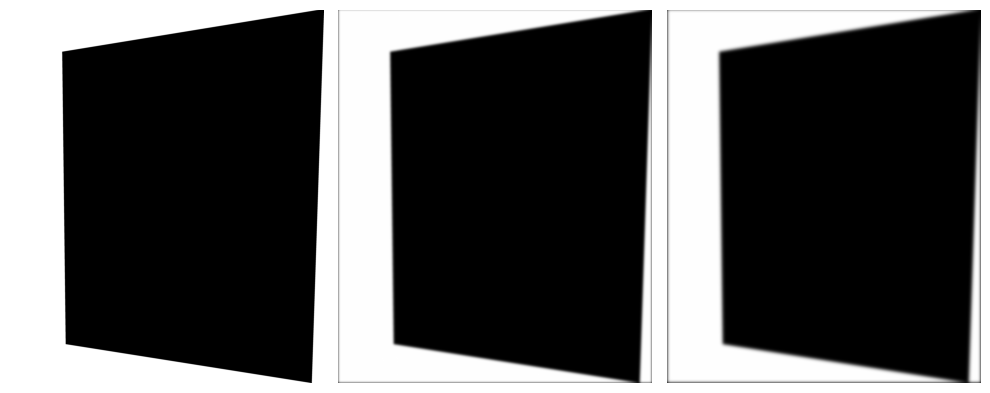

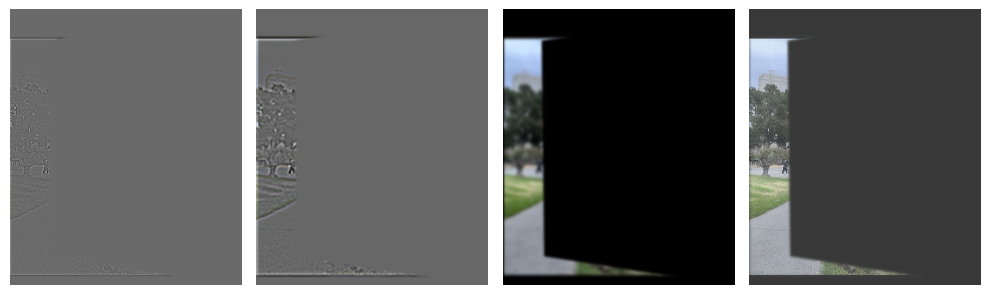

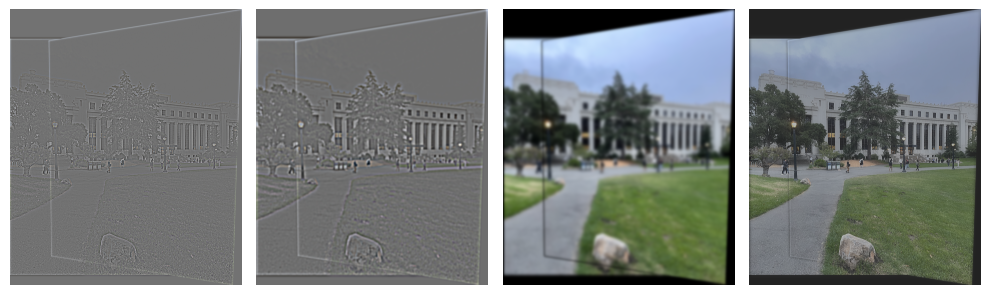

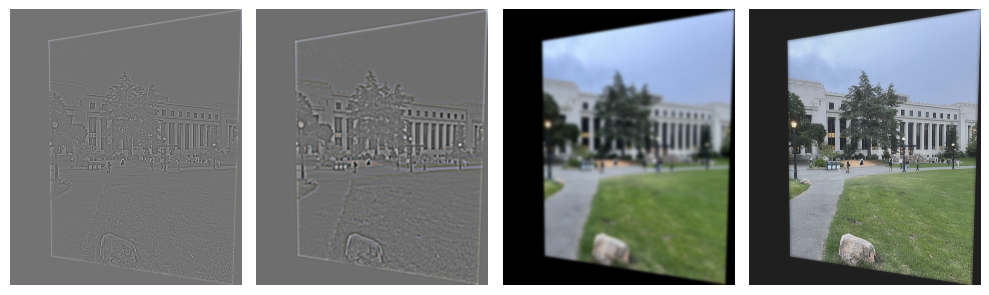

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


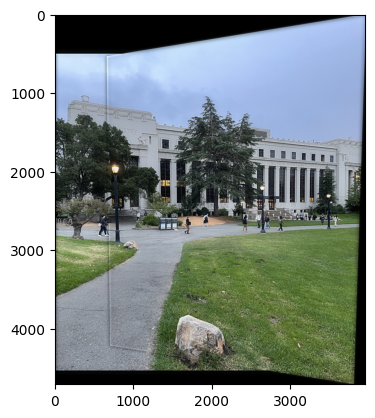

In [26]:
img_sigma = 15
mask_sigma = 15
img1 = vlsb_trans_center_img
img2 = vlsb_1_to_2_warp

final_img, left, combined, right, sky_l, nyc_l, sky_g, nyc_g = multires_blend(img1, img2, mask_2_to_1,
                                                img_sigma=img_sigma, mask_sigma=mask_sigma,
                                                save=False, fnames=['sunset', 'sunset_nyc', 'nyc'])
plt.imshow(final_img)

(6000, 6000, 3)


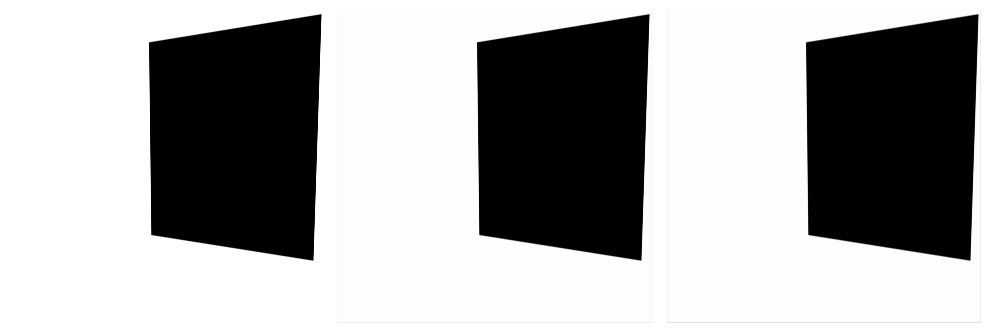

: 

In [90]:
img_sigma = 3
mask_sigma = 3
img1 = vlsb_trans_center_img
img2 = vlsb_1_to_2_warp

final_img, left, combined, right, sky_l, nyc_l, sky_g, nyc_g = multires_blend(img1, img2, mask_2_to_1,
                                                img_sigma=img_sigma, mask_sigma=mask_sigma,
                                                save=False, fnames=['sunset', 'sunset_nyc', 'nyc'])
plt.imshow(final_img)

In [ ]:
img_sigma = 3
mask_sigma = 3
img1 = vlsb_trans_center_img
img2 = vlsb_1_to_2_warp
mask = create_vertical_mask(vlsb_trans_center_img, 700)

final_img, left, combined, right, sky_l, nyc_l, sky_g, nyc_g = multires_blend(img1, img2, mask,
                                                img_sigma=img_sigma, mask_sigma=mask_sigma,
                                                save=False, fnames=['sunset', 'sunset_nyc', 'nyc'])
plt.imshow(final_img)

NameError: name 'vlsb_trans_center_img' is not defined